In [ ]:
# --- 현재 작업 경로 확인 ---
%pwd

'/home/jm/dev_ws/mldl/src'

In [ ]:
# --- 원본 데이터셋 아카이브 경로 참고 ---
# /content/drive/MyDrive/Face Mask Dataset.zip

In [ ]:
# --- 압축 해제 명령 (Colab 환경용) ---
# !unzip -qq "/content/drive/MyDrive/Face Mask Dataset.zip"

In [ ]:
# --- 학습에 필요한 라이브러리 불러오기 ---
import os
import glob

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D


In [ ]:
# --- 데이터셋 메타정보 구축 ---
path = "../data/Face Mask Dataset"
dataset = {
    "image_path" : [],
    "mask_status" : [],
    "where" : []
}

for where in os.listdir(path):
    print('Where --> : ', where)
    for status in os.listdir(path + '/' + where):
        print('\tStatus --> : ', status)
        for image in glob.glob(path + '/' + where + '/' + status + '/' + '*.png'):
            # 각 이미지의 절대 경로와 메타정보를 누적
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)

dataset = pd.DataFrame(dataset)
dataset.head()

Where --> :  Validation
	Status --> :  WithMask
	Status --> :  WithoutMask
Where --> :  Train
	Status --> :  WithMask
	Status --> :  WithoutMask
Where --> :  Test
	Status --> :  WithMask
	Status --> :  WithoutMask


,image_path,mask_status,where
0,../data/Face Mask Dataset/Validation/WithMask/...,WithMask,Validation
1,../data/Face Mask Dataset/Validation/WithMask/...,WithMask,Validation
2,../data/Face Mask Dataset/Validation/WithMask/...,WithMask,Validation
3,../data/Face Mask Dataset/Validation/WithMask/...,WithMask,Validation
4,../data/Face Mask Dataset/Validation/WithMask/...,WithMask,Validation


With Mask 5909
Without Mask 5883


<Axes: xlabel='mask_status', ylabel='count'>

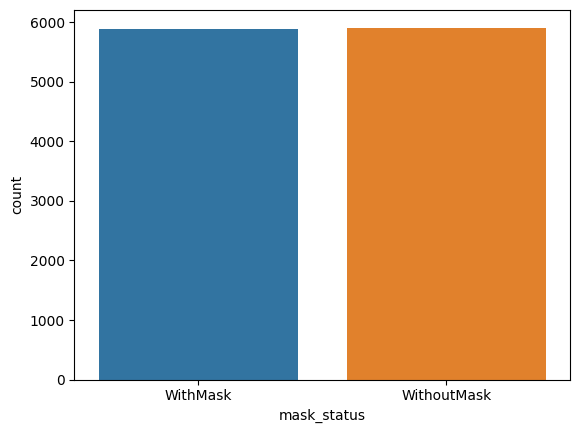

In [ ]:
# --- 클래스 분포 확인 ---
print('With Mask', dataset.value_counts('mask_status').iloc[0])
print('Without Mask', dataset.value_counts('mask_status').iloc[1])

sns.countplot(data = dataset, x = 'mask_status', hue='mask_status')

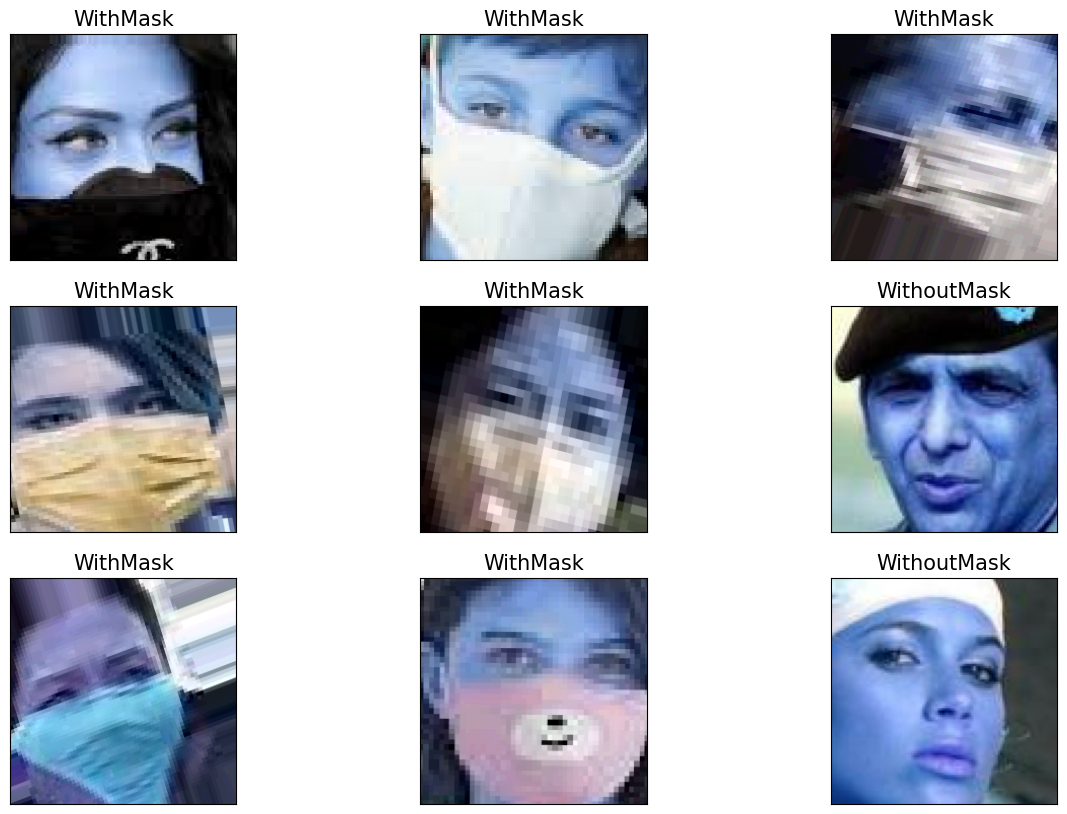

In [ ]:
# --- 무작위 샘플 시각화 ---
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.imread(dataset.loc[random, "image_path"]))
    plt.title(dataset.loc[random, "mask_status"], size=15)
    plt.xticks([])
    plt.yticks([])
plt.show()


#train, test, validation으로 각각 저장

In [ ]:
# --- 공식 train/test/validation 분리 ---
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

train_df.head(10)

,image_path,mask_status,where
800,../data/Face Mask Dataset/Train/WithMask/1395.png,WithMask,Train
801,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
802,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
803,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
804,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
805,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
806,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
807,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
808,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train
809,../data/Face Mask Dataset/Train/WithMask/Augme...,WithMask,Train


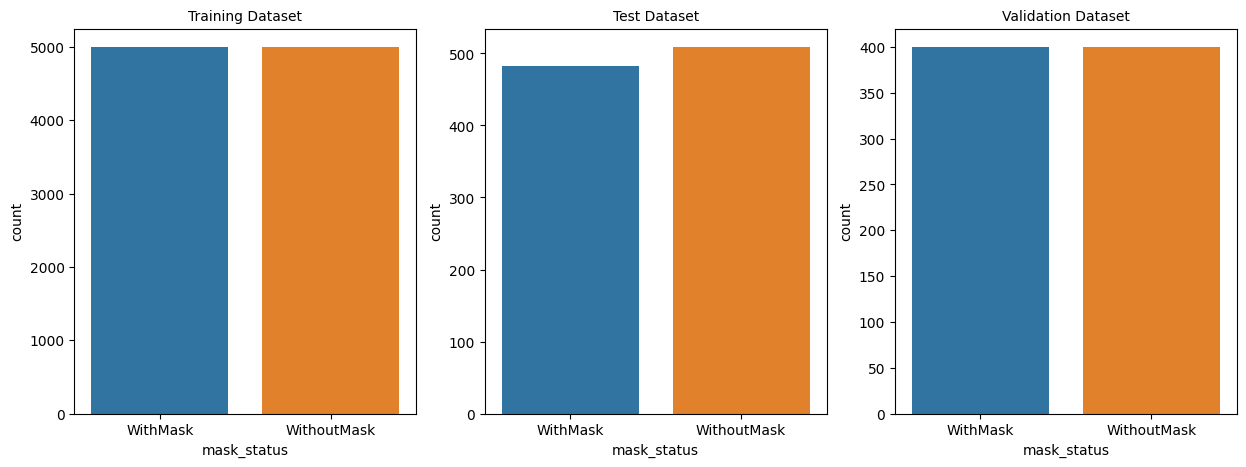

In [ ]:
# --- 각 분할 내 클래스 분포 시각화 ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=train_df, x="mask_status", hue="mask_status")
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(data=test_df, x="mask_status", hue="mask_status")
plt.title("Test Dataset", size=10)

plt.subplot(1, 3, 3)
sns.countplot(data=valid_df, x="mask_status", hue="mask_status")
plt.title("Validation Dataset", size=10)

plt.show()


In [ ]:
# --- 인덱스 초기화로 순차 접근 준비 ---
train_df = train_df.reset_index().drop("index", axis=1)
train_df.tail(10)

,image_path,mask_status,where
9990,../data/Face Mask Dataset/Train/WithoutMask/41...,WithoutMask,Train
9991,../data/Face Mask Dataset/Train/WithoutMask/51...,WithoutMask,Train
9992,../data/Face Mask Dataset/Train/WithoutMask/31...,WithoutMask,Train
9993,../data/Face Mask Dataset/Train/WithoutMask/29...,WithoutMask,Train
9994,../data/Face Mask Dataset/Train/WithoutMask/46...,WithoutMask,Train
9995,../data/Face Mask Dataset/Train/WithoutMask/86...,WithoutMask,Train
9996,../data/Face Mask Dataset/Train/WithoutMask/55...,WithoutMask,Train
9997,../data/Face Mask Dataset/Train/WithoutMask/45...,WithoutMask,Train
9998,../data/Face Mask Dataset/Train/WithoutMask/63...,WithoutMask,Train
9999,../data/Face Mask Dataset/Train/WithoutMask/56...,WithoutMask,Train


In [ ]:
# --- 원본 이미지를 grayscale 배열과 레이블로 변환 ---
data = []
image_size = 150

for i in range(len(train_df)):
    image_array = cv2.imread(train_df.loc[i, "image_path"], cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(image_array, (image_size, image_size))
    # 마스크 유무에 따라 이진 레이블 부여
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_array, 1])
    else:
        data.append([new_array, 0])

In [ ]:
# --- 학습 편향을 줄이기 위한 셔플 ---
np.random.shuffle(data)

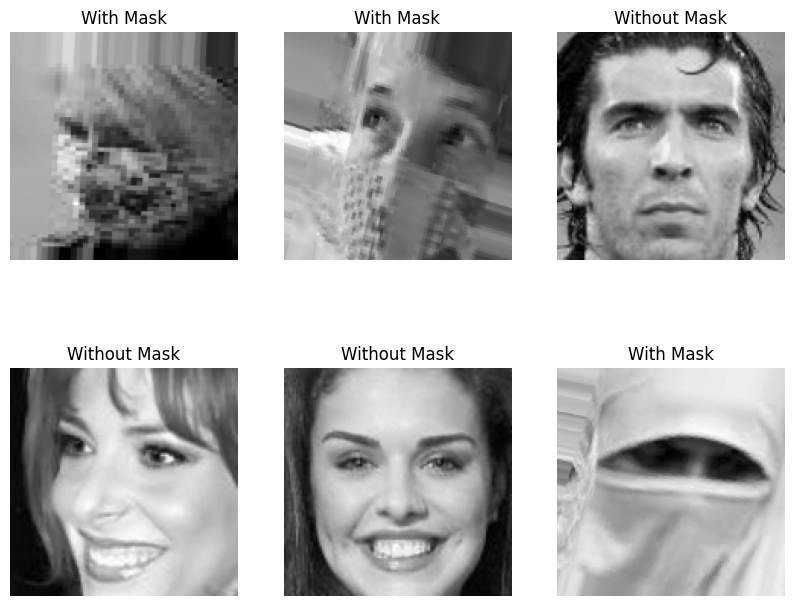

In [ ]:
# --- 전처리된 샘플을 격자 형태로 시각화 ---
fig, ax = plt.subplots(2, 3, figsize=(10, 8))

for row in range(2):
    for col in range(3):
        image_index = row * 100 + col

        ax[row, col].axis("off")
        ax[row, col].imshow(data[image_index][0], cmap="gray")

        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")

In [ ]:
# --- 샘플 데이터 구조 확인 ---
data[2]

[array([[124, 124, 124, ..., 126, 126, 126],
        [124, 124, 125, ..., 127, 126, 126],
        [124, 125, 126, ..., 127, 127, 127],
        ...,
        [157, 163, 169, ..., 150, 151, 152],
        [161, 166, 167, ..., 151, 152, 152],
        [162, 164, 159, ..., 152, 152, 153]], shape=(150, 150), dtype=uint8),
 0]

# 라벨과 데이터로 분리

In [ ]:
# --- 이미지 배열과 레이블을 분리 ---
X = []
y = []

for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

In [ ]:
# --- 학습/검증 분할 ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 13)

# 모델 구성

In [ ]:
# --- CNN 모델 정의 ---
from tensorflow.keras import layers, models

model = models.Sequential([
    # 첫 번째 합성곱 + 풀링 블록
    layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',
                  activation='relu', input_shape=(150, 150, 1)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    # 두 번째 합성곱 + 풀링 블록
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


/home/jm/venv/tf_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1765159009.001979   11351 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765159009.008687   11351 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-12-08 10:56:49.050406: W external/local

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    87,617,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,627,089 (334.27 MB)

 Trainable params: 87,627,089 (334.27 MB)

 Non-trainable params: 0 (0.00 B)